# ADAMS SS20

- Author: Kudaeva Aleksandra
- Student ID: 599943

## Introduction

In this project I try to predict the number of claps a post given text from the online publishing platform Medium based on text itself and other features provided in the dataset. 

The document is structured in the following way: 
- 1. Import the data and perform basic data profiling
- 2. Create comparable train and test datasets with the same set of variables (excluding number of claps)
- 3. Based on chosen variables we performe representativity of a test sample. Based on the results of this analzsis we filter the data so that train and test datasets have similar properties
- 4. Create additional features
- 5. Extract information from text fields
- 6. Perform dependencies analysis between claps and other features in a dataset
- 7. Apply MLP, RandomForest, Linear Regression (just as an easiest benchmark model) to the data and select the best model
- 8. Apply selected model to the data and generate file with prediction
    

In [1]:
import pandas as pd 
import numpy as np 
from matplotlib import pyplot as plt
from tqdm import tqdm, trange
import re

pd.set_option("display.max_columns", 50) #show all columns present in the dataset

## 0. Data Import 

As a first step of the analysis we import and inspect the datasets.

In [2]:
train = pd.read_csv('./ADAMS_NLPtask_SS20/Train.csv')
test = pd.read_csv('./ADAMS_NLPtask_SS20/Test.csv')

In [3]:
train.head(2)

,audioVersionDurationSec,codeBlock,codeBlockCount,collectionId,createdDate,createdDatetime,firstPublishedDate,firstPublishedDatetime,imageCount,isSubscriptionLocked,language,latestPublishedDate,latestPublishedDatetime,linksCount,postId,readingTime,recommends,responsesCreatedCount,socialRecommendsCount,subTitle,tagsCount,text,title,totalClapCount,uniqueSlug,updatedDate,updatedDatetime,url,vote,wordCount,publicationdescription,publicationdomain,publicationfacebookPageName,publicationfollowerCount,publicationname,publicationpublicEmail,publicationslug,publicationtags,publicationtwitterUsername,tag_name,slug,name,postCount,author,bio,userId,userName,usersFollowedByCount,usersFollowedCount,scrappedDate
0,0,NaN,0.0,638f418c8464,2018-09-18,2018-09-18 20:55:34,2018-09-18,2018-09-18 20:57:03,1,False,en,2018-09-18,2018-09-18 20:58:20,1,10007d3018fe,0.958491,2,0,0,A major private IT company implements blockcha...,5,"Private Business, Government and Blockchain\n\...","Private Business, Government and Blockchain",100,private-business-government-and-blockchain-100...,2018-09-18,2018-09-18 20:58:20,https://medium.com/s/story/private-business-go...,False,201,ICOBox is the first and the biggest new genera...,NaN,icobox.io,NaN,ICOBox,support@icobox.io,icobox-io,"BLOCKCHAIN,ICO,ETHEREUM,ETHEREUM BLOCKCHAIN,TO...",icobox_io,Blockchain,blockchain,Blockchain,265164.0,Anar Babaev,NaN,f1ad85af0169,babaevanar,450.0,404.0,20181104
1,0,NaN,0.0,638f418c8464,2018-09-18,2018-09-18 20:55:34,2018-09-18,2018-09-18 20:57:03,1,False,en,2018-09-18,2018-09-18 20:58:20,1,10007d3018fe,0.958491,2,0,0,A major private IT company implements blockcha...,5,"Private Business, Government and Blockchain\n\...","Private Business, Government and Blockchain",100,private-business-government-and-blockchain-100...,2018-09-18,2018-09-18 20:58:20,https://medium.com/s/story/private-business-go...,False,201,ICOBox is the first and the biggest new genera...,NaN,icobox.io,NaN,ICOBox,support@icobox.io,icobox-io,"BLOCKCHAIN,ICO,ETHEREUM,ETHEREUM BLOCKCHAIN,TO...",icobox_io,Samsung,samsung,Samsung,5708.0,Anar Babaev,NaN,f1ad85af0169,babaevanar,450.0,404.0,20181104


In [4]:
test.head(2)

,Unnamed: 0,index,Author,PublicationDetails,Responses,Header,Text,Length
0,0,0,Daniel Jeffries,"Daniel Jeffries in HackerNoon.comJul 31, 2017",627 responses,Why Everyone Missed the Most Mind-Blowing Feat...,There’s one incredible feature of cryptocurren...,23401
1,1,1,Noam Levenson,"Noam Levenson in HackerNoon.comDec 6, 2017",156 responses,NEO versus Ethereum: Why NEO might be 2018’s s...,"<img class=""progressiveMedia-noscript js-progr...",23972


While inspecting the initial datasets, I found out that many Articles are duplicated in the dataset. The columns causing duplication are not present in the test dataset and are difficult to reproduce. Therefore, I filter out just the columns I am planning to use for further analysis and delete  duplicated rows. This procedure significantly decreases dataset size and consequently processing times.

In [5]:
tr = train[['totalClapCount', 'text', 'author', 'responsesCreatedCount', 'url', 'title', 'createdDate', 'wordCount', 'language', 'imageCount']]

tr = tr.drop_duplicates(subset=None, keep='first', inplace=False)
tr.shape

(72337, 10)

In [6]:
print('Mean number of claps pro article: ', tr.totalClapCount.mean())
print('Median number of claps pro article: ', tr.totalClapCount.median())

Mean number of claps pro article:  162.63381118929456
Median number of claps pro article:  5.0


## 1. Create comparable train and test sets

In this section we are going to reproduce columns missing in the test dataset and make training and testing samples comparable. 

### 1.1 Train set

#### 1.1.1 get domain from url in train set

In [7]:
tr['Domain'] = [re.findall(r'//(.+?)/',string)[0] for string in tr['url']]

In [8]:
tr['Domain'].value_counts()

medium.com                60157
towardsdatascience.com     3641
hackernoon.com             1226
becominghuman.ai            684
chatbotslife.com            447
                          ...  
blog.picnic.nl                1
blog.vivifyideas.com          1
festivalpeak.com              1
dovetail.blog                 1
blog.showoff.ie               1
Name: Domain, Length: 1058, dtype: int64

The articles are mostly coming from Medium itself, however there are also many articles that are coming from small personal blogs and other publishing platforms.

#### 1.1.2 Rename variables in train so that they are the same as in test 

In [9]:
print('TRAIN: ', tr.columns)
print('TEST: ', test.columns)

TRAIN:  Index(['totalClapCount', 'text', 'author', 'responsesCreatedCount', 'url',
       'title', 'createdDate', 'wordCount', 'language', 'imageCount',
       'Domain'],
      dtype='object')
TEST:  Index(['Unnamed: 0', 'index', 'Author', 'PublicationDetails', 'Responses',
       'Header', 'Text', 'Length'],
      dtype='object')


In [10]:
tr.columns = ['Claps', 'Text', 'Author', 'Responces', 'URL', 'Header', 'Date', 'Length', 'Language', 'imageCount', 'Domain']

In [11]:
tr = tr.drop('URL', axis = 1)
len(tr)

72337

#### 1.1.3 Outliers

Training sample contains several articles with extreme number of claps. In total, there is less than 0.5% of articles that have more than 5000 claps. In order to make future models more robust we filter those outliers out. 

In [13]:
tr = tr[tr['Claps'] < 5000]
len(tr)

72045

### 1.2 Test set

In this section we reproduce the features missing in test dataset.

#### 1.2.1 Get domain name

In [14]:
import re
test['Domain'] = [re.findall(r'in (.+?)[A-Z][a-z]+ \d+[^.]*',string)[0] \
                  if len(re.findall(r'in (.+?)[A-Z][a-z]+ \d+[^.]*',string)) != 0 else 'NA' \
                  for string in test['PublicationDetails']]

print(test.Domain.value_counts())

Netflix TechBlog            175
NA                           93
TE-FOOD                      34
HackerNoon.com               21
The Startup                  20
                           ... 
BlockChannel                  1
Sustainable food systems      1
The Coinbase Blog             1
Real Life Stories             1
Cognitive Dissident           1
Name: Domain, Length: 106, dtype: int64


As we can see from the summary, article sources are very different in train in test datasets. As it is not possible to match them, this variable will not be considered in further analysis.

#### 1.2.2 Get date

In [15]:
test['Date'] = [re.findall('[A-Z][a-z]+ \d+[^.]*',string)[0] for string in test['PublicationDetails']]

#### 1.2.3 Define Article language 

In [16]:
# detect article language in test set
from langdetect import detect

test['Language'] = [detect(text) for text in test['Text']]
test['Language'].value_counts()

en       511
zh-tw      1
pt         1
ja         1
Name: Language, dtype: int64

#### 1.2.4 Get number of images 

In [17]:
test['imageCount'] = [len(re.findall('<img(.+?)>',string)) for string in test['Text']]

test['imageCount'].value_counts()

0     500
8       2
1       2
18      1
17      1
15      1
11      1
10      1
9       1
7       1
5       1
3       1
2       1
Name: imageCount, dtype: int64

## 2. Representativity Analysis

In order to find out if test sample and train sample have similar statistical characteristics we perform representativity analysis based on some selected features. This analysis will help to understand how trustworthy the prediction on test dataset maybe.

#### 2.1. Language 

In [18]:
tr.Language.value_counts(normalize = True)['en']

0.9173155666597266

In [19]:
test.Language.value_counts(normalize = True)

en       0.994163
zh-tw    0.001946
pt       0.001946
ja       0.001946
Name: Language, dtype: float64

99,4% of Articles in the Test dataset are English speaking, therefore we consider this neglectanble and predicte number of claps for those article as a median claps value for non-English speaking articles from Train dataset. 

Train dataset contains around 8% non-English speaking articles. As most of the tools for text processing are trained for english and test sample is almost entirely english speaking, non-English speaking articles are filtered out and not considered in any further analysis. 

In [20]:
tr_eng = tr[tr['Language'] == 'en']
tr_ne = tr[tr['Language'] != 'en']

print('Mean number of claps pro English speaking article: ', tr_eng.Claps.mean())
print('Median number of claps pro English speaking article: ', tr_eng.Claps.median())
print("")
print('Mean number of claps pro non - English speaking article: ', tr_ne.Claps.mean())
print('Median number of claps pro non - English speaking article: ', tr_ne.Claps.median())

Mean number of claps pro English speaking article:  106.43458721704394
Median number of claps pro English speaking article:  6.0

Mean number of claps pro non - English speaking article:  45.616753399362096
Median number of claps pro non - English speaking article:  3.0


In [21]:
test_eng = test[test['Language'] == 'en']
test_ne = test[test['Language'] != 'en']

#### 2.2 Authors

Another idea is to check if both datasets contain articles created by the same authors.

In [22]:
train_author = set(tr['Author'])
test_author = set(test_eng['Author'])

flag = [a in train_author for a in test_author]
print("{}% of authors in test set were in train test as well".format(round(sum(flag)/len(test_author)*100, 2)))

13.9% of authors in test set were in train test as well


However, as we can conclude from this calculation, just less than 14% of Authors from train set appear in the test dataset.

It should also be noted, that there are many Authors which wrote more than one article within each dataset. This will be further elaborated in the next chapter: Feature Engineering

In [23]:
len(train_author), len(tr)

(30934, 72045)

#### 2.3 Length of Text

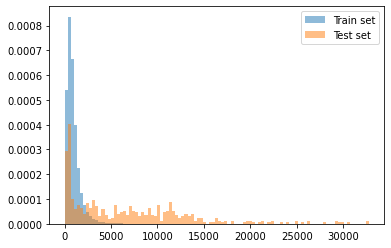

In [24]:
max_length = max(max(tr_eng['Length']), max(test_eng['Length']))
bins = np.linspace(0, max_length, 100)

plt.hist(tr_eng['Length'], bins, alpha=0.5, label='Train set', density = True) #
plt.hist(test_eng['Length'], bins, alpha=0.5, label='Test set', density = True) #
plt.legend(loc='upper right')
plt.show()

As we can see from the graph, texts in test dataset tend to be longer.

#### 2.4 Number of Images

In [25]:
tr_eng.imageCount.value_counts()

1      21573
0       9677
2       7939
3       6004
4       4623
       ...  
134        1
143        1
90         1
263        1
80         1
Name: imageCount, Length: 86, dtype: int64

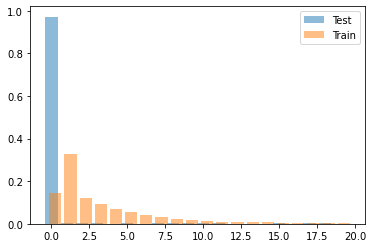

In [27]:
# train
img_tr = tr_eng.imageCount.value_counts(normalize = True).sort_index()

# clip frequencies of articles with more than 20 images 
mask = img_tr.index < 20
tail = img_tr.loc[~mask].sum()
img_tr = img_tr.loc[mask]

#img_tr['20'] = tail_prob

# test
img_test = test_eng.imageCount.value_counts(normalize = True).sort_index()

ax = plt.subplot(111)
ax.bar(x = img_test.index, height = img_test, alpha = 0.5)
ax.bar(x = img_tr.index + 0.25, height = img_tr, alpha = 0.5)
ax.legend(('Test', 'Train'))
plt.show()

As we can see, there are almost no pictures in the articles from test set. 

## 3. Additional Feature Engineering

### 3.1 Extract entities from text and calculate their number per category

In this section we extract various Named Entities from Text and calculate their number. The idea of this analysis is that different proportion of different entities in the text may characterise the topic of the article as well as the style of writing (e.g. "PERSON" and "GRE" Named Entities in the Data Science article may mean that the author uses real life examples; "QUANTITY", "PERCENT" and "MONEY" may make the article less theoretical and more result oriented) 

In order to check this hypothesis I extract number of different entities mentioned in a text by means of SpaCy NER model. 

In [28]:
import spacy

nlp = spacy.load("en_core_web_sm")


def get_entities(text):
    # Function that gets named entities of particular type or all NE if label is not specified
    # text: input string
    
    ents = nlp(text).ents
    
    PER, GPE, MONEY, ORG, LANGUAGE, QUANTITY, PERCENT, NORP = 0, 0, 0, 0, 0, 0, 0, 0

    for i in ents: 
        PER += 1 if i.label_ == 'PERSON' else 0
        GPE += 1 if i.label_ == 'GPE' else 0
        MONEY += 1 if i.label_ == 'MONEY' else 0
        ORG += 1 if i.label_ == 'ORG' else 0
        LANGUAGE += 1 if i.label_ == 'LANGUAGE' else 0
        QUANTITY += 1 if i.label_ == 'QUANTITY' else 0
        PERCENT += 1 if i.label_ == 'PERCENT' else 0
        NORP += 1 if i.label_ == 'NORP' else 0


    return (PER, GPE, MONEY, ORG, LANGUAGE, QUANTITY, PERCENT, NORP)

The following cells are deactivated because thez take around 2 hours to run. Please, activate to recalculate the results

In [ ]:
# apply fuction to all texts in train set
# list of texts
tr_texts = tr_eng['Text'].reset_index(drop = True)

mentions_tr = list(map(get_entities, tqdm(tr_texts)))

In [31]:
# apply fuction to all texts in train set
# list of texts
test_texts = test_eng['Text'].reset_index(drop = True)

mentions_test = list(map(get_entities, tqdm(test_texts)))

100%|█████████████████████████████████████████████████████████████████████████████████████████| 511/511 [01:01<00:00,  8.28it/s]


In [ ]:
# Concatenate table of mentions with initial dataset
# Because map resumes the order we do not have to take care of the index and can just concatenate

Mentions_tr = pd.DataFrame(mentions_tr, columns = ["PER", "GPE", "MONEY", "ORG", "LANGUAGE", "QUANTITY", "PERCENT", "NORP"])
tr_eng_mentions = pd.concat([tr_eng.reset_index(drop = True), Mentions_tr], axis=1)

In [36]:
# Concatenate table of mentions with initial dataset
Mentions_test = pd.DataFrame(mentions_test, columns = ["PER", "GPE", "MONEY", "ORG", "LANGUAGE", "QUANTITY", "PERCENT", "NORP"])
test_eng_mentions = pd.concat([test_eng.reset_index(drop = True), Mentions_test], axis=1)

### 3.2 Number of articles per Author 

We believe that another valuable feature that may provide valuable insides to the model is number of articles written by the same author. Unfortunately, we cannot obtain a presize number of articles per author due to dataset limitations, however we can approximately estimate this assuming that Medium is a relatively new platform that was founded in 2012. Therefore, with the dataset starting in XXX we can estimate number of articles per author resonabely good. 

In [ ]:
tr_eng_mentions['author_freq'] = tr_eng_mentions.groupby('Author')['Author'].transform('count')

In [37]:
test_eng_mentions['author_freq'] = test_eng_mentions.groupby('Author')['Author'].transform('count')

##### Save preprocessed train and test datasets to save time 

In [ ]:
tr_eng_mentions.to_csv("train_pro.csv")

In [39]:
test_eng_mentions.to_csv("test_pro.csv")

## 4. Extracting additional information from text fields

### Header classification with BERT

According to the hypothesis, number of likes depends a lot on the ability of article header to catch the attention and attrach new auditory.  


In order to get some additional information from text headers I am going to categorize number of claps and use it as a label in multiclass classification. Text classification task is going to be performed using modern architecture: BERT for text classification implemented in transformers library from HuggingFace following the BERT Fine-Tuning Tutorial with PyTorch from Chris McCormick and Nick Ryan:

Chris McCormick and Nick Ryan. (2019, July 22). BERT Fine-Tuning Tutorial with PyTorch. Retrieved from http://www.mccormickml.com

#### Import packages 

In [40]:
import pandas as pd
from tqdm import tqdm
from sklearn.preprocessing import KBinsDiscretizer as KBins
import torch

import matplotlib.pyplot as plt
import seaborn as sns

#### Get saved datasets 

In [44]:
train = pd.read_csv("train_pro.csv")
test = pd.read_csv("test_pro.csv")

In [45]:
train.columns, test.columns

(Index(['Unnamed: 0', 'Claps', 'Text', 'Author', 'Responces', 'Header', 'Date',
        'Length', 'Language', 'imageCount', 'Domain', 'PER_mentions',
        'author_freq', 'PER', 'GPE', 'MONEY', 'ORG', 'LANGUAGE', 'QUANTITY',
        'PERCENT', 'NORP'],
       dtype='object'),
 Index(['Unnamed: 0', 'Unnamed: 0.1', 'index', 'Author', 'PublicationDetails',
        'Responses', 'Header', 'Text', 'Length', 'Domain', 'Date', 'Language',
        'imageCount', 'PER', 'GPE', 'MONEY', 'ORG', 'LANGUAGE', 'QUANTITY',
        'PERCENT', 'NORP', 'author_freq'],
       dtype='object'))

In [46]:
train = train.drop( "Unnamed: 0", axis = 1)
test = test.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis = 1)

#### Define device (CPU or GPU)

In [47]:
device_name = 'cuda' if torch.cuda.is_available() else 'cpu'
device = torch.device(device_name)

#### Data loading 

In [48]:
X = train["Header"]
y = train['Claps']


# Reformat nan values in X
X = [str(i) if i != None else 'nan' for i in X]

Tried out different binning methods like quantiles and kmeans, but decided for a custom one

In [49]:
thresholds = [0, 50, 100, 200, 500, max(y)]
#labs = ['0+','50+','100+','200+','500+']
labs = [0,1,2,3,4]
y_bin = torch.LongTensor(pd.cut(y, bins = thresholds, labels = labs, include_lowest=True))

#### Load pretrained Model and Tokenizer

In [50]:
from transformers import BertTokenizer
from transformers import BertForSequenceClassification, AdamW, BertConfig


# Load the BERT tokenizer.
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# Load pretrained BERT model
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels = 6)
model.cuda()

PyTorch version 1.5.1 available.
TensorFlow version 2.2.0 available.
loading file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-vocab.txt from cache at C:\Users\MSDesktop/.cache\torch\transformers\26bc1ad6c0ac742e9b52263248f6d0f00068293b33709fae12320c0e35ccfbbb.542ce4285a40d23a559526243235df47c5f75c197f04f37d1a0c124c32c9a084
loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-config.json from cache at C:\Users\MSDesktop/.cache\torch\transformers\4dad0251492946e18ac39290fcfe91b89d370fee250efe9521476438fe8ca185.7156163d5fdc189c3016baca0775ffce230789d7fa2a42ef516483e4ca884517
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "L

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

#### Tokenize the sentences in train set

In [51]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []



# For every sentence...
for sent in tqdm(X):
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.

    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 40,           # Pad & truncate all sentences.
                        truncation=True,
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )

    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])

    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(y_bin)


  0%|                                                                                                 | 0/66088 [00:00<?, ?it/s]c:\users\msdesktop\transformers\src\transformers\tokenization_utils_base.py:1764: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
100%|███████████████████████████████████████████████████████████████████████████████████| 66088/66088 [00:13<00:00, 4976.00it/s]
<ipython-input-51-64f7885db163>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(so

#### Train - Test Split

In [52]:
from torch.utils.data import TensorDataset, random_split

# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)

# Create a 70-30 train-validation split.

# Calculate the number of samples to include in each set.
train_size = int(0.7 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

46,261 training samples
19,827 validation samples


#### Initiate Dataloaders and Batching procedure

In [53]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 32

# Create the DataLoaders for our training and validation sets.
train_dataloader = DataLoader(
            train_dataset,  
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size 
        )

# Create the DataLoaders for validation sets
validation_dataloader = DataLoader(
            val_dataset, 
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size 
        )

#### Set hyperparameters 

In [54]:
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )


In [55]:
from transformers import get_linear_schedule_with_warmup


# After running training procedure for several times with 4 epochs, I saw that there are signs of overfitting
epochs = 2

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)


#### Helper functions

In [56]:
import numpy as np
import time
import datetime

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

#### Training 

In [57]:
import random
import numpy as np

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0
    # Set model to training mode
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Time: {:}.'.format(step, len(train_dataloader), elapsed))

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].type('torch.LongTensor').to(device)
        
        model.zero_grad()        

        loss, logits = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)
        
        
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()

        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].type('torch.LongTensor').to(device)

        with torch.no_grad():        
            
            (loss, logits) = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # Accumulate current batch accuracy to the total epoch accuracy 
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 2 ========
Training...
  Batch    40  of  1,446.    Time: 0:00:11.
  Batch    80  of  1,446.    Time: 0:00:22.
  Batch   120  of  1,446.    Time: 0:00:33.
  Batch   160  of  1,446.    Time: 0:00:43.
  Batch   200  of  1,446.    Time: 0:00:54.
  Batch   240  of  1,446.    Time: 0:01:05.
  Batch   280  of  1,446.    Time: 0:01:16.
  Batch   320  of  1,446.    Time: 0:01:27.
  Batch   360  of  1,446.    Time: 0:01:38.
  Batch   400  of  1,446.    Time: 0:01:49.
  Batch   440  of  1,446.    Time: 0:02:00.
  Batch   480  of  1,446.    Time: 0:02:11.
  Batch   520  of  1,446.    Time: 0:02:21.
  Batch   560  of  1,446.    Time: 0:02:32.
  Batch   600  of  1,446.    Time: 0:02:43.
  Batch   640  of  1,446.    Time: 0:02:54.
  Batch   680  of  1,446.    Time: 0:03:05.
  Batch   720  of  1,446.    Time: 0:03:15.
  Batch   760  of  1,446.    Time: 0:03:26.
  Batch   800  of  1,446.    Time: 0:03:37.
  Batch   840  of  1,446.    Time: 0:03:48.
  Batch   880  of  1,446.    Time

In [58]:
import pandas as pd

# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
stats = pd.DataFrame(data=training_stats).set_index('epoch')
stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.99,0.97,0.7,0:06:32,0:00:40
2,0.92,0.97,0.7,0:06:29,0:00:39


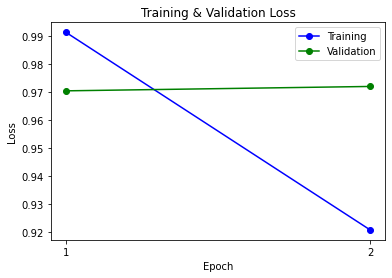

In [59]:
# Plot the learning curve.
plt.plot(stats['Training Loss'], 'b-o', label="Training")
plt.plot(stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2])

plt.show()

Initially, I have also tried 4 epochs, however already on the third one there were signs of overfitting (after second epoch validation loss starts to grow and accuracy to fall). In general, authors of the model recommend to set number of epochs between 2 and 4.

##### Evaluate on test set 

In [60]:
prediction_data = val_dataset
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)

    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch

    # Telling the model not to compute or store gradients, saving memory and 
    # speeding up prediction
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

    logits = outputs[0]

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    # Store predictions and true labels
    predictions.append(logits)
    true_labels.append(label_ids)


In [61]:
from sklearn.metrics import classification_report

# Combine the results across all batches. 
flat_predictions = np.concatenate(predictions, axis=0)

# For each sample, pick the label (0 or 1) with the higher score.
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = np.concatenate(true_labels, axis=0)

target_names = ["0","1","2","3","4"]
print ('\nClasification report:\n', classification_report(flat_true_labels, flat_predictions, target_names=target_names))


Clasification report:
               precision    recall  f1-score   support

           0       0.71      0.99      0.83     13877
           1       0.00      0.00      0.00      2060
           2       0.00      0.00      0.00      1574
           3       0.20      0.07      0.10      1287
           4       0.40      0.03      0.06      1029

    accuracy                           0.70     19827
   macro avg       0.26      0.22      0.20     19827
weighted avg       0.53      0.70      0.59     19827



c:\program files\python38\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


As we can see, the dataset is imbalanced. Therefore declaired accuracy is exagerrated. In order to get more insights, we visually compare distribution of preditions and true labels among groups.

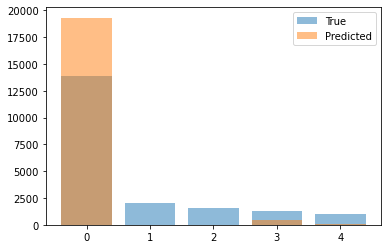

In [63]:
df = pd.DataFrame(zip(flat_true_labels, flat_predictions), columns = ['True_Label', 'Predicted'])
pred = df.Predicted.value_counts()
true = df.True_Label.value_counts()

# Plot the distribution
plt.bar(true.index, true, alpha=0.5, label='True') #
plt.bar(pred.index, pred, alpha=0.5, label='Predicted') #
plt.legend(loc='upper right')
plt.show()

#### Create a column in train dataset with predicted Header class

in order to use model results in further analysis we apply the model to the whole dataset another time and save predicted class to the separate column.

In [64]:
prediction_data = dataset

prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)

    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
  
    # Telling the model not to compute or store gradients, saving memory and 
    # speeding up prediction
    with torch.no_grad():
        # Forward pass, calculate logit predictions
        outputs = model(b_input_ids, token_type_ids=None, 
                          attention_mask=b_input_mask)

    logits = outputs[0]

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    # Store predictions and true labels
    predictions.append(logits)
    true_labels.append(label_ids)

In [65]:
# Combine the results across all batches. 
flat_predictions = np.concatenate(predictions, axis=0)

# For each sample, pick the label (0 or 1) with the higher score.
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

train['Header_class'] = flat_predictions

##### Apply fine-tuned model to the test dataset

In [66]:
# Create sentence and label lists
sentences = [str(i) for i in test.Header.values]

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# tokenize sentences
for sent in tqdm(sentences):
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 40,           # Pad & truncate all sentences.
                        truncation = True, 
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )

    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)

# Set the batch size.  
batch_size = 32  

# Create the DataLoader.
prediction_data = TensorDataset(input_ids, attention_masks)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions = []

# Predict 
for batch in prediction_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)

    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask = batch

    # Telling the model not to compute or store gradients, saving memory and 
    # speeding up prediction
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

    logits = outputs[0]

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()

    # Store predictions and true labels
    predictions.append(logits)

# Combine the results across all batches. 
flat_predictions = np.concatenate(predictions, axis=0)

# For each sample, pick the label (0 or 1) with the higher score.
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

  0%|                                                                                                   | 0/511 [00:00<?, ?it/s]c:\users\msdesktop\transformers\src\transformers\tokenization_utils_base.py:1764: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
100%|███████████████████████████████████████████████████████████████████████████████████████| 511/511 [00:00<00:00, 5314.64it/s]


In [67]:
test['Header_class'] = flat_predictions

## 5. Check dependence of claps to different variables

### 5.1 Responces

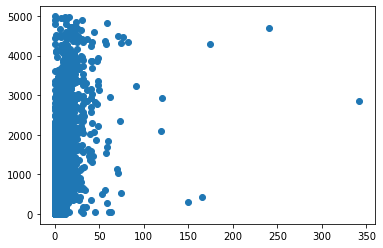

In [68]:
plt.scatter(train['Responces'], train['Claps'])
plt.show()

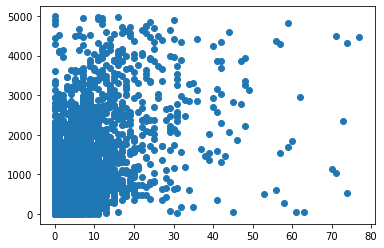

In [69]:
filtered = train[train['Responces']< 80]
plt.scatter(filtered['Responces'], filtered['Claps'])
plt.show()

### 5.2 Number of Articles per Author 

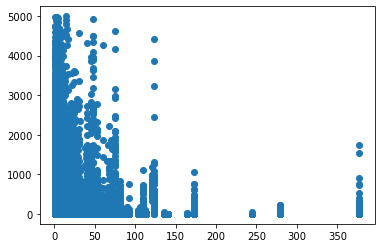

In [70]:
plt.scatter(train['author_freq'], train['Claps'])
plt.show()

From plot we can notice that too many articles is not a good sign either. However, lets delete outliers and look at the graph ones again

### 5.3 Number of Images in the Article 

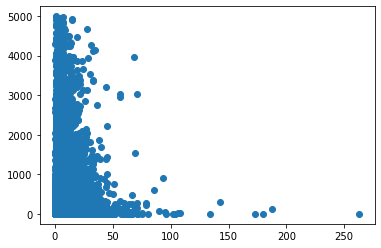

In [71]:
plt.scatter(train['imageCount'], train['Claps'])
plt.show()

### 5.4 Modelled Header Category 

In [72]:
# calculate average number of claps from header category
avg = train.groupby('Header_class')['Claps'].mean()
avg

Header_class
0     95.09
3    423.72
4    674.47
Name: Claps, dtype: float64

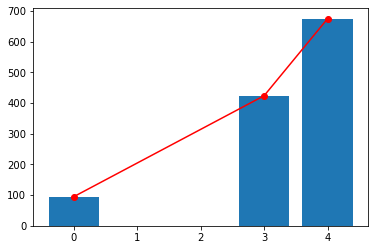

In [73]:
plt.bar(avg.index, height = avg)
plt.plot(avg.index, avg, color = "r", marker='o')

plt.show()

As we can see from the graph the average number of claps per predicted categorz adequately reflects the interval. However, there are no predictions for intervals (50, 100] and (100, 200]. This can be solved by grouping those categories together or retraining the model with different groupings. As group labels are ordinal numbers, we do not perform any further transformations on this variable.

In the previous experiments I have also tried to split data into mode categories, but the clap rate was not monotonously raising. Therefore, I have combined categories [0,20] and (20, 50] into one and retrained the model. 

### 5.5 Claps vs. number of Entities in Text 

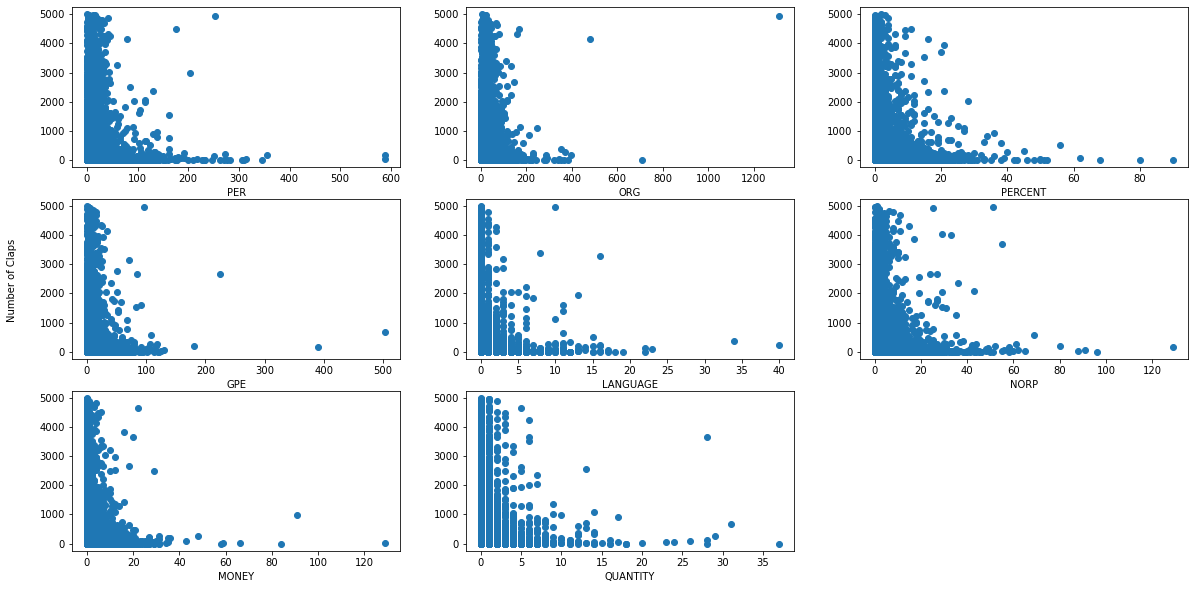

In [75]:
fig, ax = plt.subplots(3, 3, figsize=(20,10))

# PER
ax[0, 0].scatter(train['PER'], train['Claps'])
ax[1, 0].scatter(train['GPE'], train['Claps'])
ax[2, 0].scatter(train['MONEY'], train['Claps'])
ax[0, 1].scatter(train['ORG'], train['Claps'])
ax[1, 1].scatter(train['LANGUAGE'], train['Claps'])
ax[2, 1].scatter(train['QUANTITY'], train['Claps'])
ax[0, 2].scatter(train['PERCENT'], train['Claps'])
ax[1, 2].scatter(train['NORP'], train['Claps'])


fig.text(0.08, 0.5, 'Number of Claps', va='center', rotation='vertical')

ax[0, 0].set(xlabel="PER")
ax[1, 0].set(xlabel="GPE")
ax[2, 0].set(xlabel="MONEY")
ax[0, 1].set(xlabel="ORG")
ax[1, 1].set(xlabel="LANGUAGE")
ax[2, 1].set(xlabel="QUANTITY")
ax[0, 2].set(xlabel="PERCENT")
ax[1, 2].set(xlabel="NORP")

fig.delaxes(ax[2, 2])
plt.show()

As can be seen from the graph above, for all entities there is a tendency of having less claps if more Named Entities are mentioned in the text. 

## 7. Modelling Claps

### 7.0. Train - test split

In [77]:
from sklearn.model_selection import train_test_split

X = train.drop('Claps', axis = 1)
y = train['Claps']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)
print('Training sample contains: {} samples and {} variables'.format(X_train.shape[0], X_train.shape[1]))
print('Test sample contains: {} samples and {} variables'.format(X_test.shape[0], X_test.shape[1]))

Training sample contains: 46261 samples and 20 variables
Test sample contains: 19827 samples and 20 variables


In [78]:
#leave just the columns that enter the model
X_train = X_train.drop(['Header', 'Text', 'Author', 'Language', 'Domain', 'Date'], axis = 1)
X_test = X_test.drop(['Header', 'Text', 'Author', 'Language', 'Domain', 'Date'], axis = 1)

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(46261, 13) (19827, 13)
(46261,) (19827,)


### 7.1. Build neural network for regression

In [79]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model


from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import numpy as np
import argparse
import locale
import os

In [80]:
def create_mlp(dim, regress=True):
    # define our MLP network
    model = Sequential()
    
    # add a hidden layer
    model.add(Dense(8, input_dim=dim, activation="relu"))
    model.add(Dense(4, activation="relu"))
    
    # add the regression node
    model.add(Dense(1, activation="linear"))
    
    return model

In [81]:
# training setting
model = create_mlp(X_train.shape[1], regress=True)
opt = Adam(lr=1e-2, decay=1e-3 / 20)
model.compile(loss="mean_squared_error", optimizer=opt)
model.summary()

# train the model
print("[INFO] training model...")
model.fit(x=X_train, y=y_train, validation_data=(X_test, y_test), epochs=40, batch_size=16)

score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 112       
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 36        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 5         
Total params: 153
Trainable params: 153
Non-trainable params: 0
_________________________________________________________________
[INFO] training model...
Epoch 1/40
2892/2892 [==============================] - 4s 2ms/step - loss: 108553.9531 - val_loss: 62961.4688
Epoch 2/40
2892/2892 [==============================] - 4s 2ms/step - loss: 85847.5312 - val_loss: 58124.8906
Epoch 3/40
2892/2892 [==============================] - 4s 2ms/step - loss: 72515.4141 - val_loss: 73182.8984
Epoch 4/40
2892/2892 [==========

### 7.2. Create a Random Forest Classifier as a benchmark for loss

In [89]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error

clf = RandomForestClassifier(max_depth=6, random_state=0)
clf.fit(X_train, y_train)

pred = clf.predict(X_test)

print("MSE of Linear Regression on the Validation Set (30%): ", round(mean_squared_error(y_test, pred), 2))

MSE of Linear Regression on the Validation Set (30%):  122928.91


### 7.3. Try out linear regression as a benchmark for loss 

In [84]:
# Linear Regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

reg = LinearRegression()
reg.fit(X_train, y_train)
pred = reg.predict(X_test)

print("MSE of Linear Regression on the Validation Set (30%): ", round(mean_squared_error(y_test, pred), 2))

MSE of Linear Regression on the Validation Set (30%):  81783.2


## 8. Evaluation of results with best model 

In [133]:
tst = test.drop(['Header', 'Text', 'Author', 'Language', 'Domain', 'Date', "PublicationDetails", "index"], axis = 1)
index = test['index']
tst['Responses'] = tst.Responses.str.extract('(\d+)').astype(float)

In [144]:
# 1. predict number of Claps with MLP for english articles
pred = model.predict(tst)
test_eng_pred = pd.DataFrame(zip(index, pred), columns = ['index', 'Claps'])
# 2. predict with average value for non-English articles
idx_ne = test_ne['index']
len_ne = len(idx_ne)
pred_ne = [tr_ne.Claps.median()]*len_ne

test_ne_pred = pd.DataFrame(zip(idx_ne, pred_ne), columns = ['index', 'Claps'])

# 3. concatenate dataset and sort by index
result = pd.concat([test_eng_pred, test_ne_pred]).sort_values('index')

In [151]:
result.to_csv('Sample_sumission.csv')